In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
# import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np

In [28]:
config = pymatcal.get_config('../configs/config.yml')
pointA = np.array([5, 5, 0])
cuboid = np.array([5, 5.2, 5, 5.3, -0.5, 0.5, 1, 0.48])
radial_shift = 0.3
det_subs = pymatcal.get_det_subdivcoords(cuboid, config['det nsub'])
subdiv_inc = np.array([config['mmpvx'][0]/config['img nsub']
                      [0], config['mmpvx'][1]/config['img nsub'][1]])
subcentroids = pymatcal.get_img_subdivcoords(config)+pointA
pAs = subcentroids
pBs = det_subs['coords']+np.array([radial_shift, 0, 0])
# pymatcal.get_intersections_2d(np.array([cuboid]), pAs, pBs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)
geom = np.array([5.1, 5.2, 5.1, 5.15, -.5, 0.5, 1, 0.48])
geom_dim = (geom[1:-2:2]-geom[0:-2:2])
geom_o = (geom[0:-2:2]+geom[1:-2:2])*0.5
ab_rect_o = (abpairs[:, 0:3]+abpairs[:, 3:6])*0.5
ab_rect_dim = np.abs(abpairs[:, 0:3]-abpairs[:, 3:6])
oodist = np.abs(ab_rect_o-geom_o)
condition = np.all(oodist < (ab_rect_dim+geom_dim)*0.5,axis=1)

In [32]:
print(condition.shape)
print(condition)
print(abpairs[condition].shape)

(64,)
[False  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True False  True]
(32, 6)


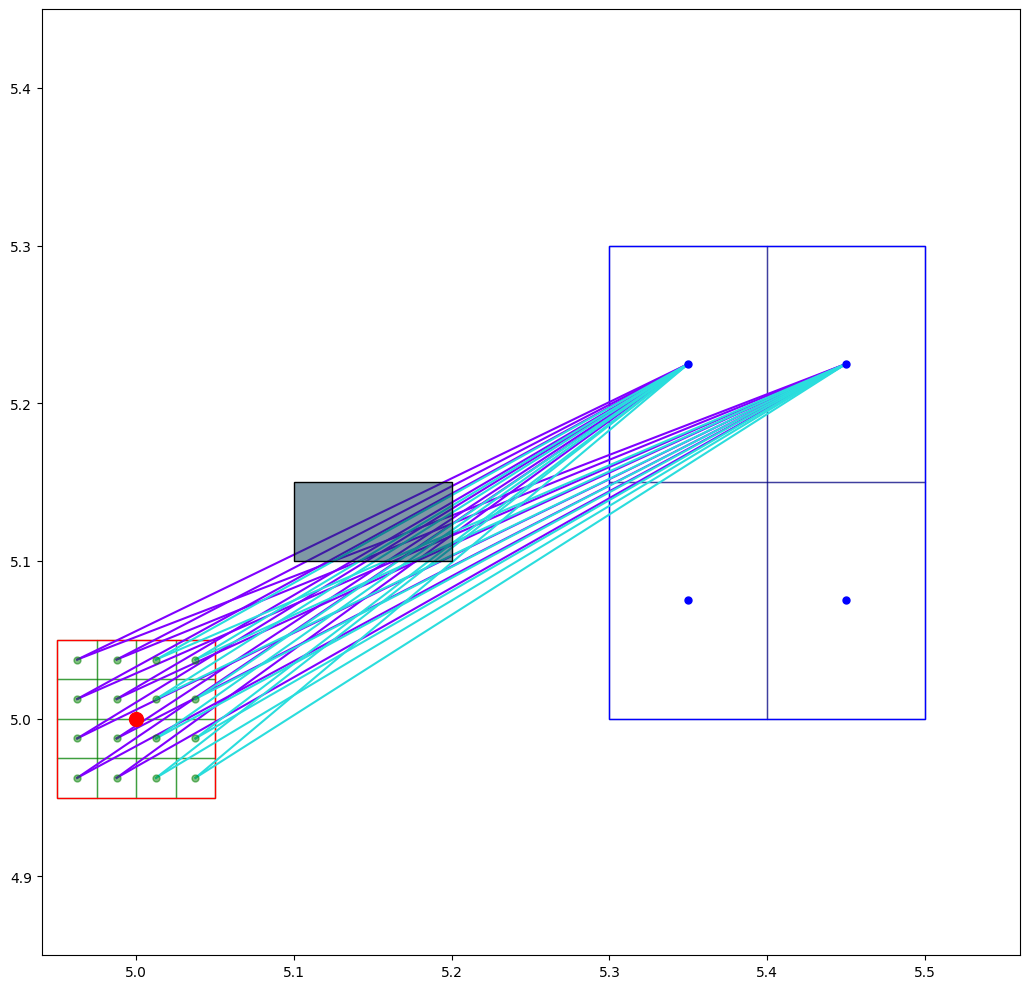

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt


det_subdiv_list = [mpl.patches.Rectangle(
    xy[:2]-det_subs['incs'][:2]*0.5, det_subs['incs'][0], det_subs['incs'][1]) for xy in pBs]

img_subdiv_list = [mpl.patches.Rectangle(
    xy-subdiv_inc*0.5, subdiv_inc[0], subdiv_inc[1]) for xy in subcentroids[:, :2]]
fig, ax = plt.subplots(figsize=(12, 10))
pc = mpl.collections.PatchCollection(
    img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc='none')
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc='none')
nb=pBs.shape[0]
na=pAs.shape[0]
color = plt.cm.rainbow(np.linspace(0, 1, nb))
idx=0
for pair in abpairs[condition]:
    ax.plot(pair[0::3], pair[1::3], ',-',c=color[idx // na],ms=10)
    idx += 1
# print(subcentroids)
ax.plot(subcentroids[:, 0], subcentroids[:, 1],
        '.', color=(0, 0.5, 0, 0.5), ms=10)
ax.plot(det_subs['coords'][:, 0]+radial_shift, det_subs['coords'][:, 1],
        '.', color=(0, 0, 1, 1), ms=10)
ax.plot(pointA[0], pointA[1], 'r.', ms=20)
ax.set_xlim(pointA[0]-config['mmpvx'][0]*0.6, pointA[0] +
            config['mmpvx'][0]*.6+radial_shift+cuboid[1]-cuboid[0])
ax.set_ylim(np.min(np.asarray([pointA[1]-config['mmpvx'][1]*0.6, cuboid[2]-0.5*(cuboid[3]-cuboid[2])])),
            np.max(np.asarray([pointA[1]+config['mmpvx'][1]*.6, cuboid[3]+0.5*(cuboid[3]-cuboid[2])])))
ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_patch(mpl.patches.Rectangle(
    (pointA-config['mmpvx']*0.5)[:2], config['mmpvx'][0], config['mmpvx'][1], fc='none', ec='r'))

ax.add_patch(mpl.patches.Rectangle(
    (cuboid[0]+radial_shift, cuboid[2]), cuboid[1]-cuboid[0], cuboid[3]-cuboid[2], fc='none', ec='b'))
ax.add_patch(mpl.patches.Rectangle(
    (geom[0], geom[2]), geom[1]-geom[0], geom[3]-geom[2], fc=(0,0.2,0.3,0.5), ec='k',zorder=10))
ax.set_aspect('equal')
fig.tight_layout()

In [68]:

def findt_2d(geom, abpairs):
    # Case 1: intersects on face x = x_0 or face x = x_1
    # Note that A_x never equals B_x.
    tx0 = (abpairs[:, 0]-geom[0]) / (abpairs[:, 0] - abpairs[:, 3])
    tx1 = (abpairs[:, 0]-geom[1]) / (abpairs[:, 0] - abpairs[:, 3])
    yx0 = tx0 * (abpairs[:, 4] - abpairs[:, 1]) + abpairs[:, 1]
    yx1 = tx1 * (abpairs[:, 4] - abpairs[:, 1]) + abpairs[:, 1]
    condition_x0 = np.all(np.array([yx0 > geom[2], yx0 < geom[3]]), axis=0)
    condition_x1 = np.all(np.array([yx1 > geom[2], yx1 < geom[3]]), axis=0)
    # Case 2: intersects on face y = y_0 or face y = y_1
    # Note: we exclude the case when A_y equals B_y
    abpairs_y = abpairs[abpairs[:, 1] != abpairs[:, 4]]
    ty0 = (abpairs_y[:, 1] - geom[2]) / (abpairs_y[:, 1] - abpairs_y[:, 4])
    ty1 = (abpairs_y[:, 1] - geom[3]) / (abpairs_y[:, 1] - abpairs_y[:, 4])
    xy0 = ty0 * (abpairs_y[:, 3] - abpairs_y[:, 0]) + abpairs_y[:, 0]
    xy1 = ty1 * (abpairs_y[:, 3] - abpairs_y[:, 0]) + abpairs_y[:, 0]
    condition_y0 = np.all(np.array([xy0 > geom[0], xy0 < geom[1]]), axis=0)
    condition_y1 = np.all(np.array([xy1 > geom[0], xy1 < geom[1]]), axis=0)
    ts = np.array([np.where(condition_x0, tx0, 0), np.where(condition_x1, tx1, 0),
             np.where(condition_y0, ty0, 0), np.where(condition_y1, ty1, 0)])
    return np.sort(ts,axis=0)[-2:]


print(findt_2d(geom, abpairs[condition]).shape)

(2, 32)
